### Natural Language Processing with Disaster Tweets

### Introduction

This project aims to perform sentiment analysis on the Disaster Tweets dataset in order to classify whether tweets pertain to real disasters or not. Methods to achieve this included utilizing Long Short-Term Memory networks (LSTMs), Gated Recurrent Units (GRUs), and a combination of the two in order to optimize model performance for this Kaggle competition.

### Dataset

The dataset includes tweets labeled as 1 (relating to real disasters) or 0 (not relating to disasters) for training, and unlabeled tweets used for the testing and Kaggle submission. Tweets varied in styles and included things such as hashtags, URLs, punctuation, mentions, and emojis. Because of this complexity, the data was preprocessed with tokenization, removing punctuation, mentions, hashtags, emojis, and stopwords to name a few methods.

### Modeling Process

The modeling process included an LSTM model, a GRU model, and then a combination of the two methods. Features like dropout and dense layers were also added.

### Importing Packages

In [32]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import re
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import contractions

from collections import Counter

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM, GRU, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

In [2]:
train_file = 'train.csv'
train_df = pd.read_csv(train_file)
test_file = 'test.csv'
test_df = pd.read_csv(test_file)

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print(f'Train data shape: {train_df.shape}')
print(f'Test data shape: {test_df.shape}')

Train data shape: (7613, 5)
Test data shape: (3263, 4)


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [7]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

### 1. Data Preprocessing

In [8]:
def clean_text(text):
    stop = stopwords.words('english')
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    #clean test

    #remove url
    text = re.sub(r'http\S+|www.\S+', '', text)

    #remove @mentions
    text = re.sub(r'@\w+', '', text)

    #remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    #lowercase
    text = text.lower()

    #remove hashtag symbol # but keep the word
    text = re.sub(r'#(\w+)', r'\1', text)

    #remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop])

    #lemmatization
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

In [9]:
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
train_df.head()

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['cleaned_text'].values)
sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'].values)

In [11]:
x = pad_sequences(sequences, maxlen = 100)
y = train_df['target'].values

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 100, stratify = y)

In [12]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y_train),
                                                  y = y_train)

In [13]:
class_weights_dict = dict(enumerate(class_weights))

In [14]:
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

In [15]:
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'].values)
x_test = pad_sequences(test_sequences, maxlen = 100)

### 2. Exploratory Data Analysis

#### 2.1 Target Distribution

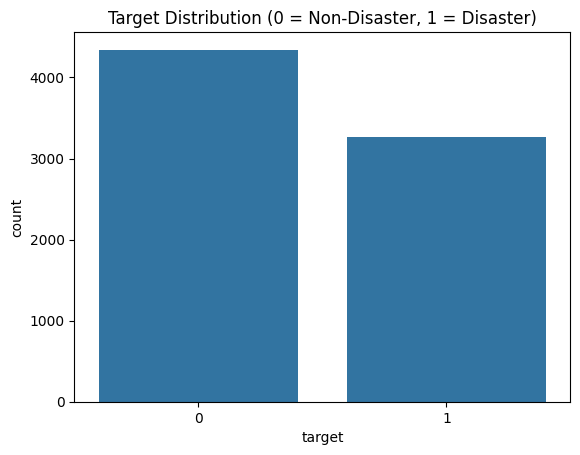

In [16]:
sns.countplot(x = train_df['target'])
plt.title('Target Distribution (0 = Non-Disaster, 1 = Disaster)')
plt.show()

#### 2.1 Word Count Distribution

In [17]:
train_df['word_count'] = train_df['cleaned_text'].apply(lambda x: len(x.split()))

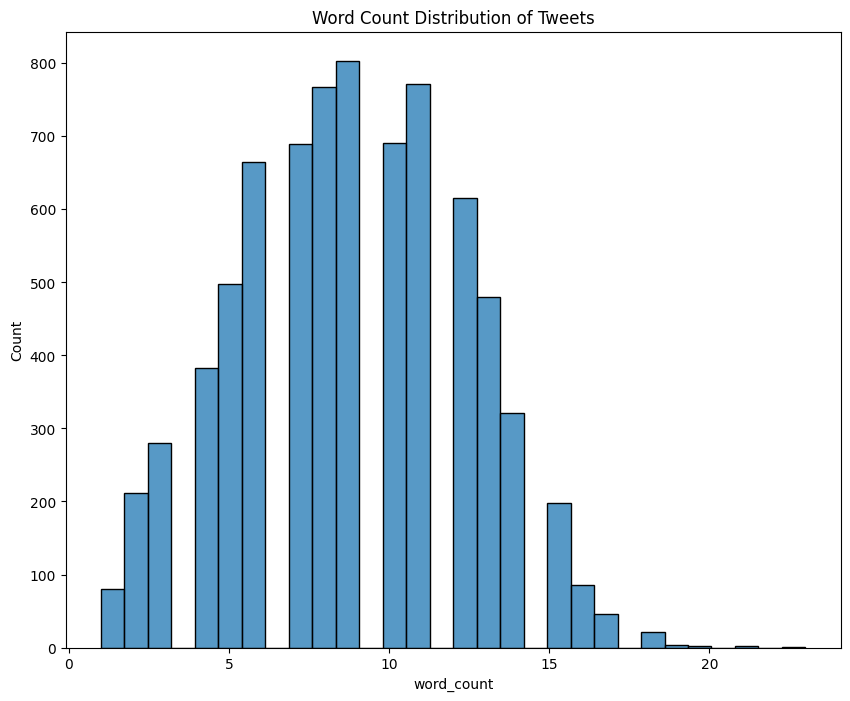

In [18]:
plt.figure(figsize = (10, 8))
sns.histplot(train_df['word_count'], bins = 30)
plt.title('Word Count Distribution of Tweets')
plt.show()

In [19]:
all_words = ' '.join([text for text in train_df['cleaned_text']])

In [20]:
word_freq = Counter(all_words.split())

In [21]:
common_words = word_freq.most_common(20)

In [22]:
common_words_df = pd.DataFrame(common_words, columns = ['word', 'frequency'])

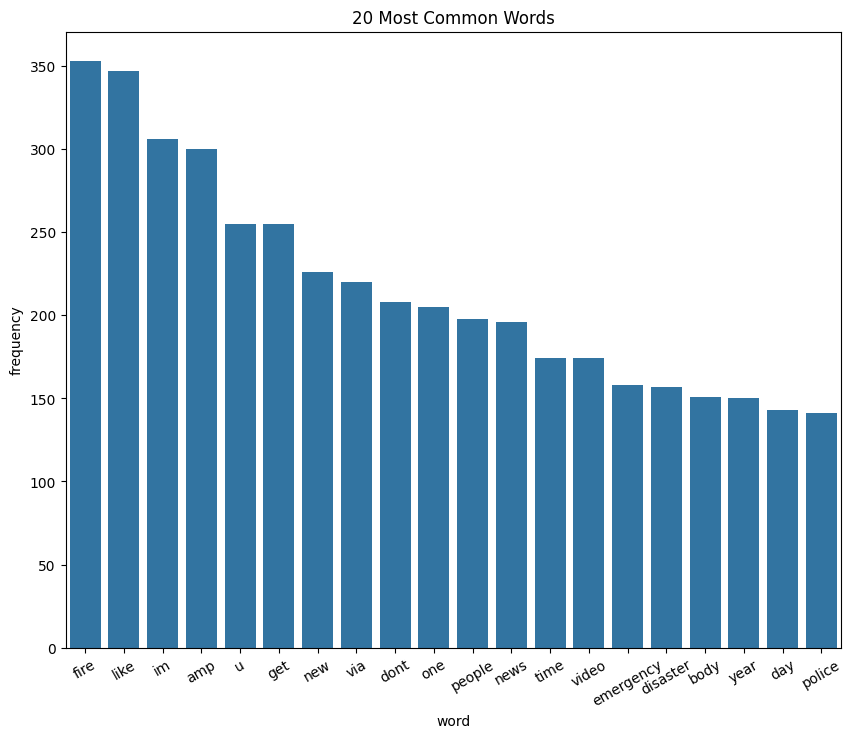

In [23]:
plt.figure(figsize = (10, 8))
sns.barplot(x = 'word', y = 'frequency', data = common_words_df)
plt.xticks(rotation = 30),
plt.title('20 Most Common Words')
plt.show()

In [24]:
train_df['word_count'] = train_df['cleaned_text'].apply(lambda x: len(x.split()))

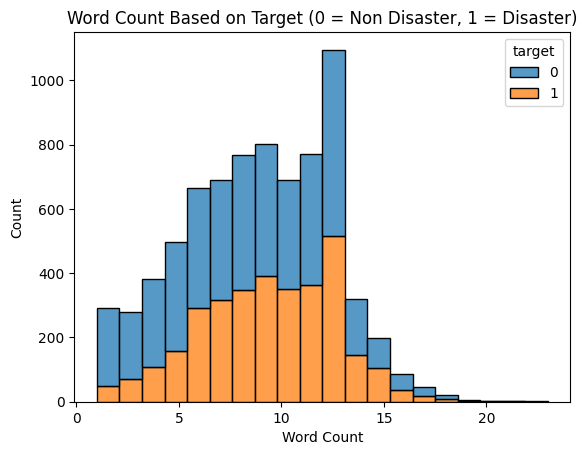

In [25]:
sns.histplot(data = train_df, x = 'word_count', hue = 'target', multiple = 'stack', bins = 20)
plt.title('Word Count Based on Target (0 = Non Disaster, 1 = Disaster)')
plt.xlabel('Word Count')
plt.show()

In [26]:
train_df['char_count'] = train_df['cleaned_text'].apply(len)

#### 2.2 Character Distribution

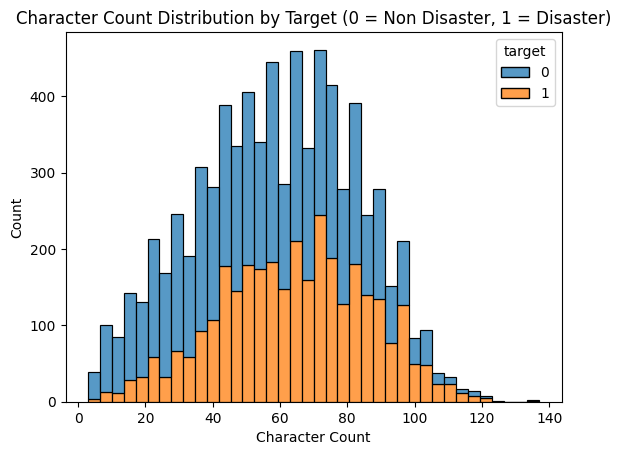

In [27]:
sns.histplot(data = train_df, x = 'char_count', hue = 'target', multiple = 'stack')
plt.title('Character Count Distribution by Target (0 = Non Disaster, 1 = Disaster)')
plt.xlabel('Character Count')
plt.show()

#### 2.3 Tweet Length vs Target

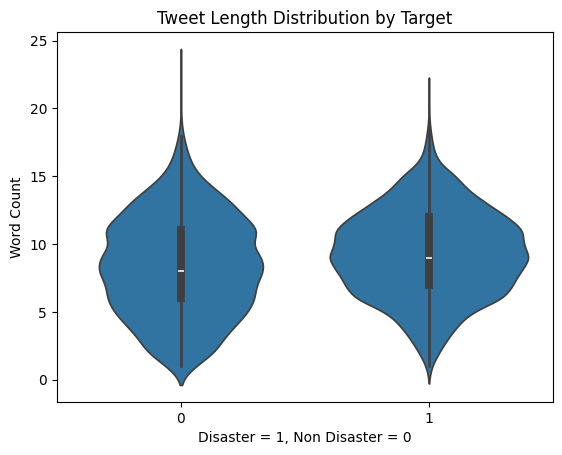

In [28]:
sns.violinplot(x = 'target', y = 'word_count', data = train_df)
plt.title('Tweet Length Distribution by Target')
plt.xlabel('Disaster = 1, Non Disaster = 0')
plt.ylabel('Word Count')
plt.show()

#### 2.4 Hashtags in Text

In [29]:
train_df['hashtag_count'] = train_df['text'].apply(lambda x: len([word for word in x.split() if word.startswith('#')]))

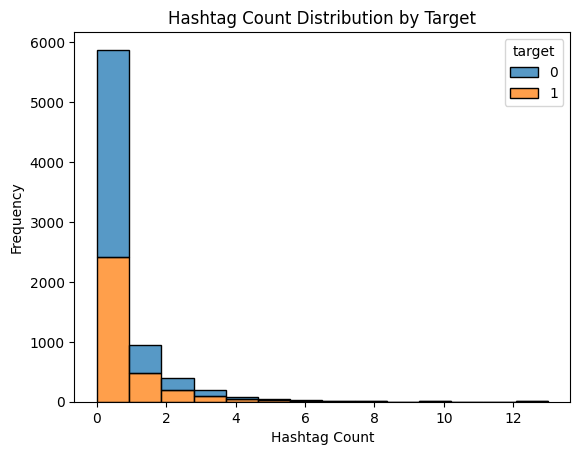

In [30]:
sns.histplot(data = train_df, x = 'hashtag_count', hue = 'target', multiple = 'stack')
plt.title('Hashtag Count Distribution by Target')
plt.xlabel('Hashtag Count')
plt.ylabel('Frequency')
plt.show()

#### 2.5 Mentions (@username) vs. Target

In [31]:
train_df['mention_count'] = train_df['text'].apply(lambda x: len([word for word in x.split() if word.startswith('@')]))

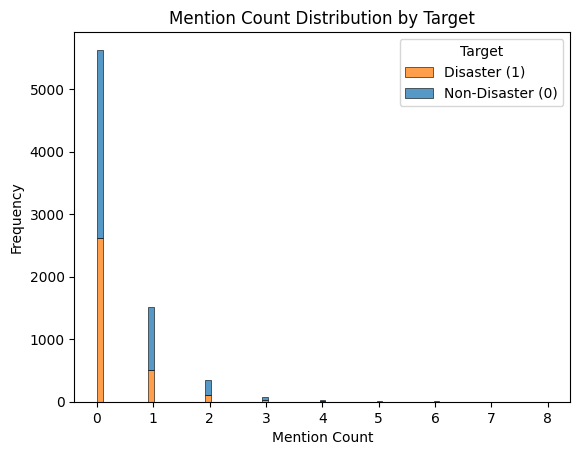

In [32]:
sns.histplot(data = train_df, x = 'mention_count', hue = 'target', hue_order = [0, 1], multiple = 'stack')
plt.title('Mention Count Distribution by Target')
plt.xlabel('Mention Count')
plt.ylabel('Frequency')
plt.legend(title = 'Target',
           loc = 'upper right',
           labels = ['Disaster (1)','Non-Disaster (0)'])
plt.show()

#### 2.6 Distribution of Locations

In [33]:
location_counts = train_df['location'].value_counts().head(10)

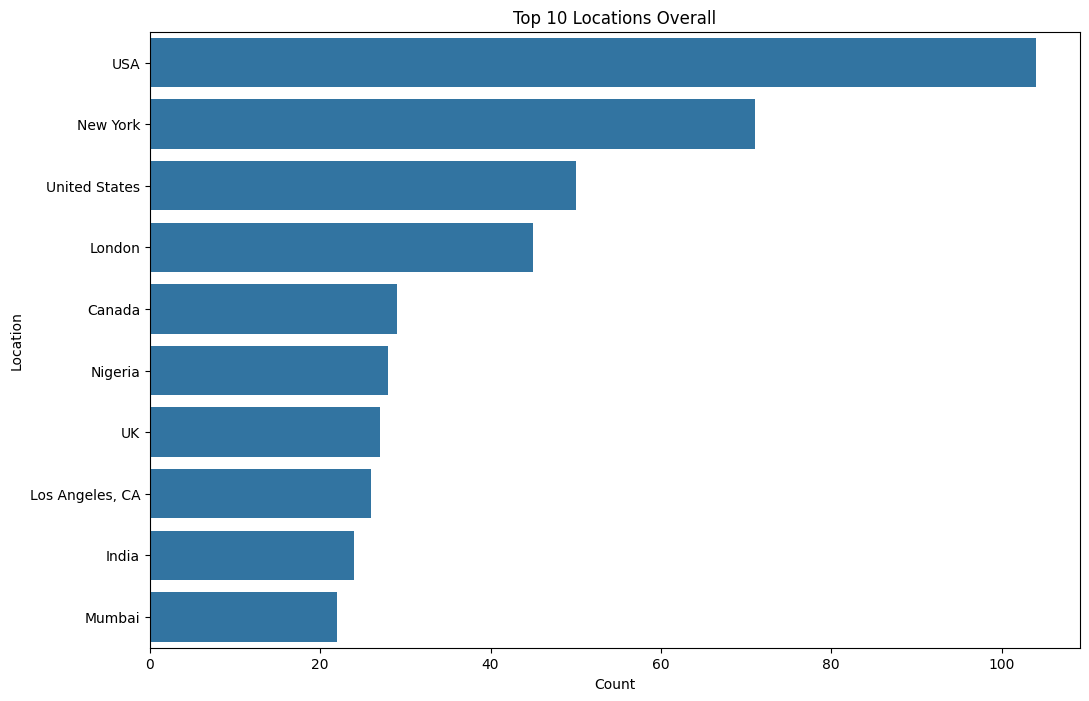

In [34]:
plt.figure(figsize = (12, 8))
sns.barplot(x = location_counts.values, y = location_counts.index)
plt.title('Top 10 Locations Overall')
plt.xlabel('Count')
plt.ylabel('Location')
plt.show()

#### 2.7 Location vs. Target

In [35]:
location_counts_filtered = train_df[train_df['location'].notnull()]

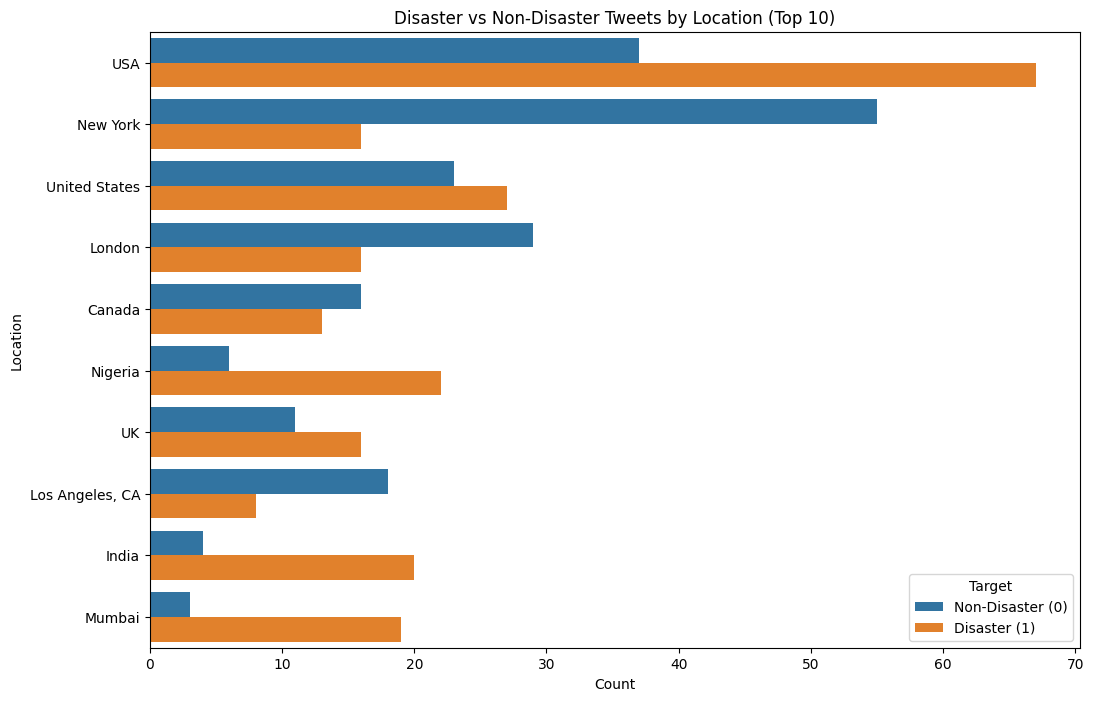

In [36]:
plt.figure(figsize = (12, 8))
sns.countplot(y = 'location',
              data = location_counts_filtered,
              hue = 'target',
              hue_order = [0, 1],
              order = location_counts_filtered['location'].value_counts().index[:10])
plt.title('Disaster vs Non-Disaster Tweets by Location (Top 10)')
plt.xlabel('Count')
plt.ylabel('Location')
plt.legend(title = 'Target',
           loc = 'lower right',
           labels = ['Non-Disaster (0)', 'Disaster (1)'])
plt.show()

#### 2.8 Keyword Distribution

In [37]:
keyword_counts_10 = train_df['keyword'].value_counts().head(10)

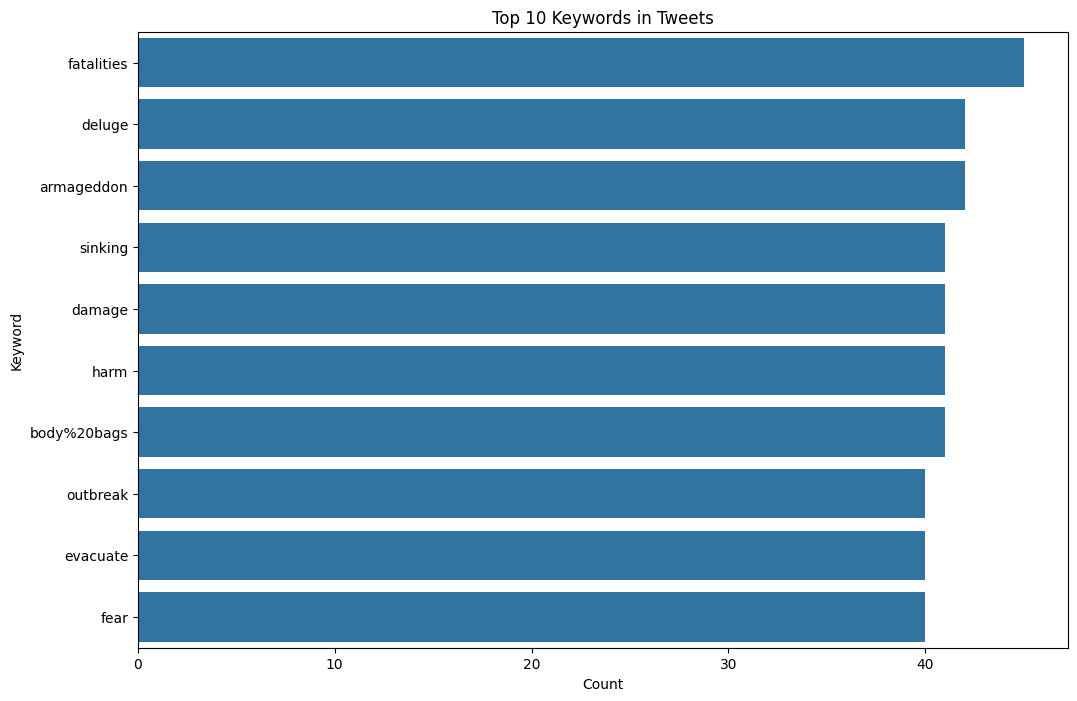

In [38]:
plt.figure(figsize = (12, 8))
sns.barplot(x = keyword_counts_10.values, y = keyword_counts_10.index)
plt.title('Top 10 Keywords in Tweets')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.show()

In [39]:
keyword_filtered = train_df[train_df['keyword'].notnull()]

In [40]:
keyword_filtered.head()

,id,keyword,location,text,target,cleaned_text,word_count,char_count,hashtag_count,mention_count
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,wholesale market ablaze,3,23,0,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,always try bring heavy metal rt,6,31,2,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,africanbaze breaking newsnigeria flag set abla...,7,52,1,0
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,cry set ablaze,3,14,0,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,plus side look sky last night ablaze,7,36,0,0


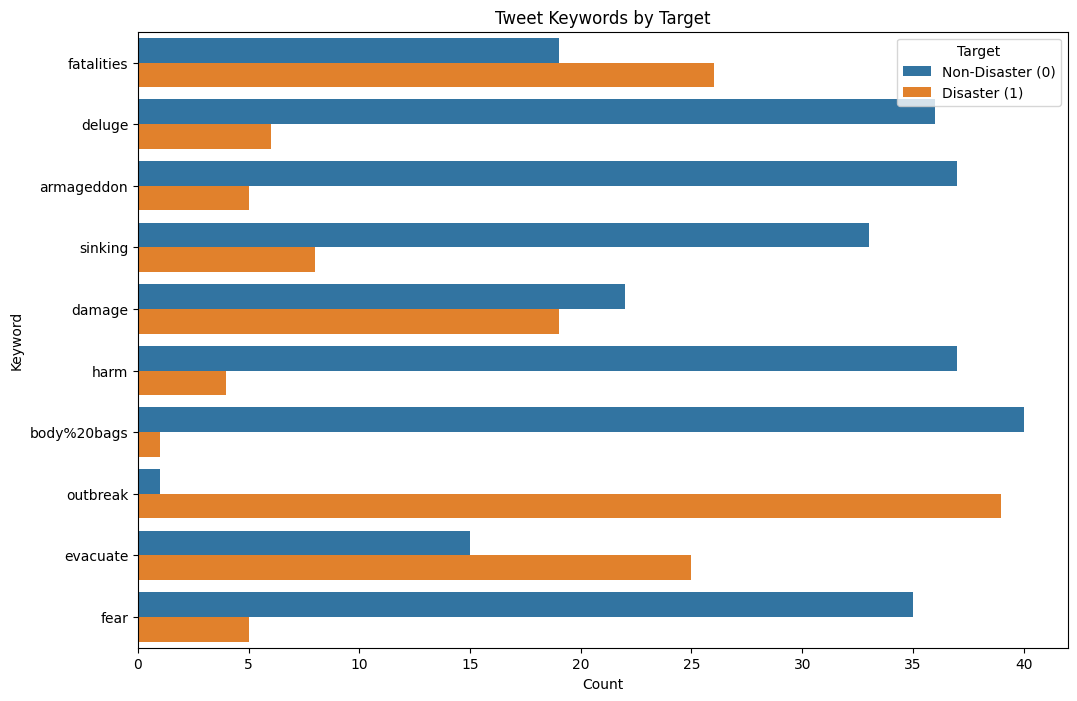

In [41]:
plt.figure(figsize = (12, 8))
sns.countplot(y = 'keyword',
              data = keyword_filtered,
              hue = 'target',
              hue_order = [0, 1],
              order = keyword_filtered['keyword'].value_counts().index[:10])
plt.title('Tweet Keywords by Target')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.legend(title = 'Target',
           loc = 'upper right',
           labels = ['Non-Disaster (0)', 'Disaster (1)'])
plt.show()

### 3. Modeling

#### 3.1 LSTM Model

In [17]:
strategy = tf.distribute.get_strategy()
print('Number of devices:', strategy.num_replicas_in_sync)

Number of devices: 1


In [43]:
with strategy.scope():
    model1 = Sequential()
    model1.add(Embedding(input_dim = 10000,
                         output_dim = 128))
    model1.add(LSTM(units = 32,
                    return_sequences = True))
    model1.add(Dropout(0.5))
    model1.add(Dense(32,
                     activation = 'relu',
                     kernel_regularizer = l2(0.001)))
    model1.add(LSTM(units = 16))
    model1.add(Dropout(0.5)),
    model1.add(Dense(16,
                     activation = 'relu',
                     kernel_regularizer = l2(0.001))),
    model1.add(Dense(1,
                     activation = 'sigmoid'))

    
    model1.compile(optimizer = 'adam',
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])
    
    print(model1.summary())
    
    checkpoint = ModelCheckpoint(filepath='model1.h5',
                                 monitor='val_loss',
                                 save_best_only = True,
                                 mode = 'min',
                                 verbose = 1)

    early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 3,
                               restore_best_weights = True)
    
    history_model1 = model1.fit(x_train,
                                y_train,
                                validation_data = (x_val, y_val),
                                epochs = 10,
                                callbacks = [checkpoint, early_stopping],
                                batch_size = 64)

2024-10-20 18:25:01.747417: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-10-20 18:25:01.747466: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-10-20 18:25:01.747472: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-10-20 18:25:01.747506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-20 18:25:01.747523: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 lstm (LSTM)                 (None, None, 32)          20608     
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 dense (Dense)               (None, None, 32)          1056      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                2

2024-10-20 18:25:02.932901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - ETA: 0s - loss: 0.6788 - accuracy: 0.6259
Epoch 1: val_loss improved from inf to 0.52793, saving model to model1.h5
96/96 [==============================] - 9s 74ms/step - loss: 0.6788 - accuracy: 0.6259 - val_loss: 0.5279 - val_accuracy: 0.7702
Epoch 2/10
 2/96 [..............................] - ETA: 5s - loss: 0.4345 - accuracy: 0.8281

/Users/Monica/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/96 [============================>.] - ETA: 0s - loss: 0.4216 - accuracy: 0.8355
Epoch 2: val_loss improved from 0.52793 to 0.49749, saving model to model1.h5
96/96 [==============================] - 6s 62ms/step - loss: 0.4214 - accuracy: 0.8356 - val_loss: 0.4975 - val_accuracy: 0.7892
Epoch 3/10
95/96 [============================>.] - ETA: 0s - loss: 0.2781 - accuracy: 0.9066
Epoch 3: val_loss did not improve from 0.49749
96/96 [==============================] - 6s 60ms/step - loss: 0.2779 - accuracy: 0.9067 - val_loss: 0.5682 - val_accuracy: 0.7722
Epoch 4/10
95/96 [============================>.] - ETA: 0s - loss: 0.2118 - accuracy: 0.9324
Epoch 4: val_loss did not improve from 0.49749
96/96 [==============================] - 6s 60ms/step - loss: 0.2118 - accuracy: 0.9325 - val_loss: 0.7041 - val_accuracy: 0.7492
Epoch 5/10
95/96 [============================>.] - ETA: 0s - loss: 0.1608 - accuracy: 0.9512
Epoch 5: val_loss did not improve from 0.49749
96/96 [===================

In [20]:
def plot_training_performance(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc), + 1)

    #accuracy plot
    plt.figure(figsize = (12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, 'o-', label = 'Training Accuracy')
    plt.plot(val_acc, 'o-', label = 'Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc = 'upper left')

    #loss plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, 'o-', label = 'Training Loss')
    plt.plot(val_loss, 'o-', label = 'Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc = 'upper right')
    
    plt.tight_layout()
    plt.show

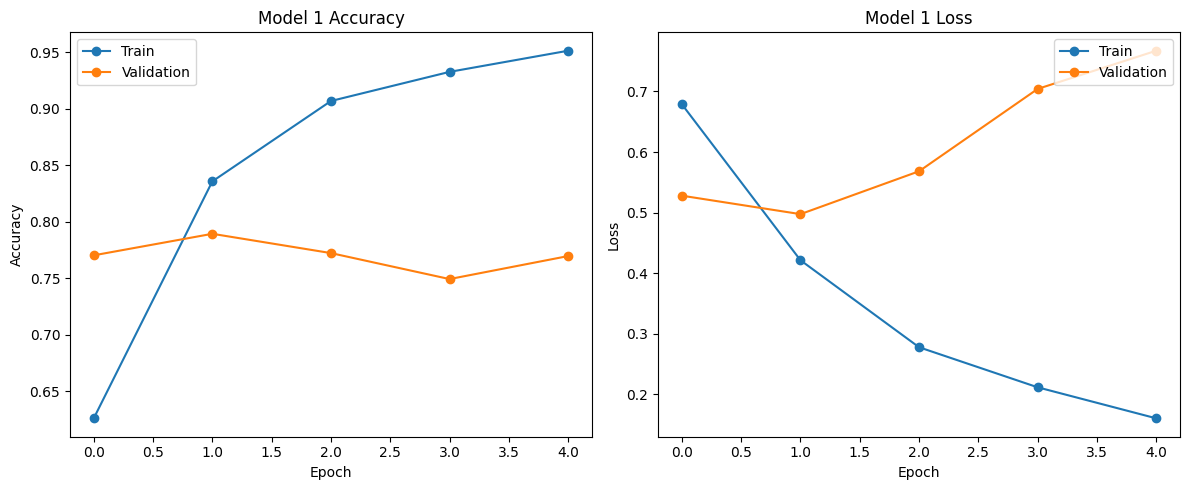

In [45]:
plot_training_performance(history_model1, "Model 1")

##### 3.1.2 Testing

In [25]:
def model_test(model, test_input):
    predicitons = model.predict(test_input)
    predicted_classes = (predicitons > 0.5).astype(int).flatten()

    return predicted_classes

In [27]:
test_ids = test_df['id']
test_ids = test_ids.to_numpy()

In [48]:
model1 = load_model("model1.h5")

In [49]:
model1_predicted_classes = model_test(model1, x_test)

102/102 [==============================] - 1s 8ms/step


In [24]:
def model_results_df(test_id, predicted_classes):
    results_df = pd.DataFrame({
        'id': test_id,
        'target': predicted_classes
    })
    
    return results_df

In [29]:
def save_model_results(results_df, model, results_fname = 'results.csv', model_fname = 'model.keras'):
    
    #save results df to csv
    results_df.to_csv(results_fname, index = False)
    print(f'Results saved to {results_fname}')

    #save model to .keras format
    model.save(model_fname)
    print(f'Model saved as {model_fname}')


In [52]:
model1_results_df = model_results_df(test_ids, model1_predicted_classes)

In [54]:
save_model_results(model1_results_df, model1, 'model1_results.csv', 'model1.keras')

Results saved to model1_results.csv
Model saved as model1.keras


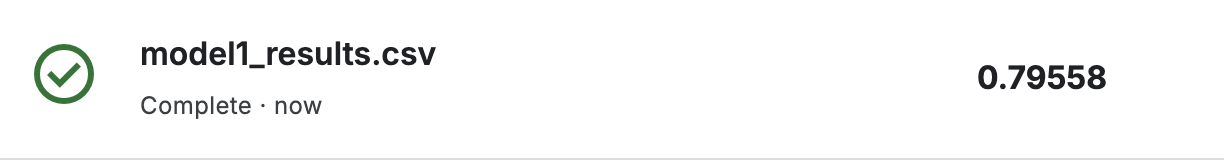

#### 3.2 GRU

In [55]:
with strategy.scope():
    model2 = Sequential()
    model2.add(Embedding(input_dim = 10000,
                         output_dim = 128,
                         input_length = 100))
    model2.add(GRU(units = 128,
                   return_sequences = True))
    model2.add(Dropout(0.2))
    model2.add(GRU(units = 64))
    model2.add(Dropout(0.2))
    model2.add(Dense(1, activation = 'sigmoid'))
    
    model2.compile(optimizer = 'adam',
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])
    
    print(model2.summary)

    checkpoint = ModelCheckpoint(filepath='model2.h5',
                                 monitor='val_loss',
                                 save_best_only = True,
                                 mode = 'min',
                                 verbose = 1)

    early_stopping = EarlyStopping(monitor = 'val_loss',
                                   patience = 3,
                                   restore_best_weights = True)
    
    history_model2 = model2.fit(x_train,
                                y_train,
                                validation_data = (x_val, y_val),
                                epochs = 10,
                                callbacks = [checkpoint, early_stopping],
                                batch_size = 64)

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x31fa0bf70>>
Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 0.5290 - accuracy: 0.7322
Epoch 1: val_loss improved from inf to 0.48417, saving model to model2.h5
96/96 [==============================] - 6s 52ms/step - loss: 0.5290 - accuracy: 0.7322 - val_loss: 0.4842 - val_accuracy: 0.7840
Epoch 2/10
95/96 [============================>.] - ETA: 0s - loss: 0.2940 - accuracy: 0.8796
Epoch 2: val_loss did not improve from 0.48417
96/96 [==============================] - 4s 44ms/step - loss: 0.2939 - accuracy: 0.8798 - val_loss: 0.5688 - val_accuracy: 0.7748
Epoch 3/10
95/96 [============================>.] - ETA: 0s - loss: 0.1973 - accuracy: 0.9238
Epoch 3: val_loss did not improve from 0.48417
96/96 [==============================] - 4s 41ms/step - loss: 0.1972 - accuracy: 0.9240 - val_loss: 0.6231 - val_accuracy: 0.7663
Epoch 4/10
95/96 [============================>.] - ETA: 0s - los

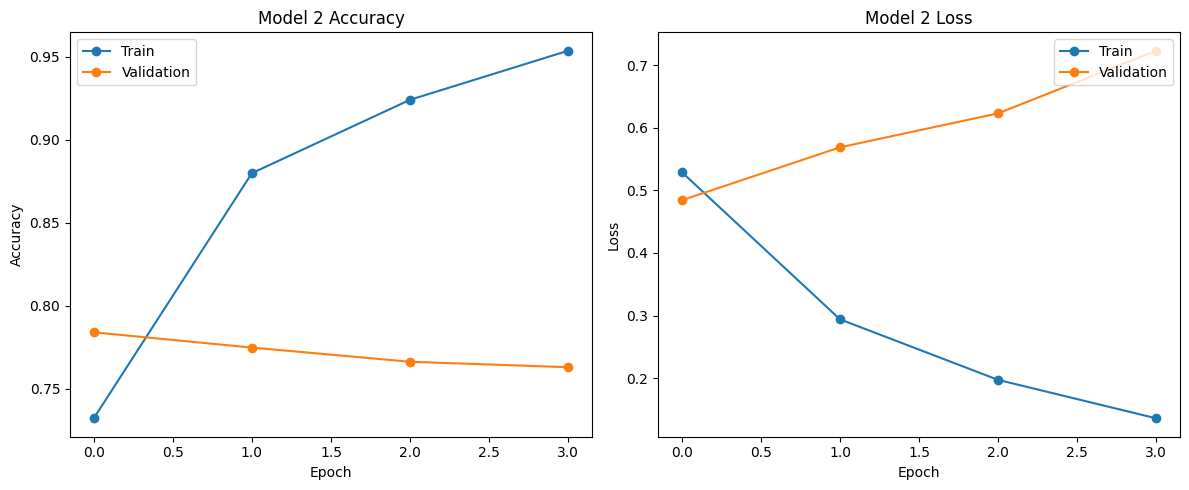

In [56]:
plot_training_performance(history_model2, "Model 2")

In [57]:
model2 = load_model("model2.h5")

In [58]:
model2_predicted_classes = model_test(model2, x_test)

102/102 [==============================] - 1s 10ms/step


In [59]:
model2_results_df = model_results_df(test_ids, model2_predicted_classes)

In [60]:
save_model_results(model2_results_df, model2, 'model2_results.csv', 'model2.keras')

Results saved to model2_results.csv
Model saved as model2.keras


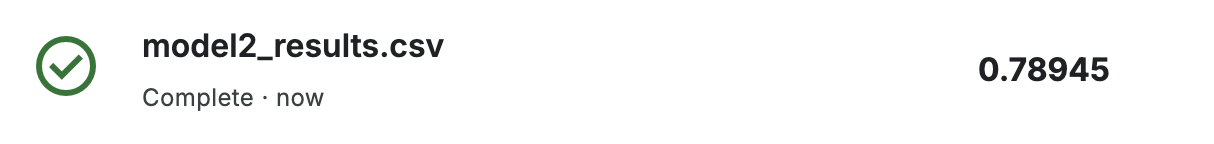

#### 3.3 Model 3

Combined approach of LSTM and GRU

In [46]:
with strategy.scope():
    model3 = Sequential()
    model3.add(Embedding(input_dim = 10000,
                         output_dim = 128,
                         input_length = 100))

    model3.add(LSTM(units = 128,
                    return_sequences = True,
                    kernel_regularizer = l2(0.001)))
    model3.add(Dropout(0.3))
    model3.add(BatchNormalization())

    model3.add(LSTM(units = 64,
                return_sequences = True,
                kernel_regularizer = l2(0.001)))
    model3.add(Dropout(0.3))
    model3.add(BatchNormalization())

    
    model3.add(GRU(units = 64,
                   return_sequences = True,
                   kernel_regularizer = l2(0.001)))
    model3.add(Dropout(0.3))
    model3.add(BatchNormalization())

    
    model3.add(GRU(units = 32,
                   kernel_regularizer = l2(0.001)))
    model3.add(Dropout(0.3))
    model3.add(BatchNormalization())


    model3.add(Dense(units = 64,
                     activation = 'relu',
                     kernel_regularizer = l2(0.001)))
    model3.add(Dropout(0.5))


    model3.add(Dense(units = 32,
                     activation = 'relu',
                     kernel_regularizer = l2(0.001)))
    model3.add(Dropout(0.5))
    
    model3.add(Dense(1, activation = 'sigmoid'))
    
    model3.compile(optimizer = 'adam',
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])
    
    print(model3.summary)

    checkpoint = ModelCheckpoint(filepath='model3.h5',
                                 monitor='val_loss',
                                 save_best_only = True,
                                 mode = 'min',
                                 verbose = 1)

    early_stopping = EarlyStopping(monitor = 'val_loss',
                                   patience = 3,
                                   restore_best_weights = True)
    
    history_model3 = model3.fit(x_train,
                                y_train,
                                validation_data = (x_val, y_val),
                                epochs = 10,
                                callbacks = [checkpoint, early_stopping],
                                batch_size = 64)

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x392939a00>>
Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 1.4074 - accuracy: 0.5184
Epoch 1: val_loss improved from inf to 1.12016, saving model to model3.h5
96/96 [==============================] - 15s 118ms/step - loss: 1.4074 - accuracy: 0.5184 - val_loss: 1.1202 - val_accuracy: 0.5706
Epoch 2/10
96/96 [==============================] - ETA: 0s - loss: 1.1620 - accuracy: 0.5350
Epoch 2: val_loss improved from 1.12016 to 1.06754, saving model to model3.h5
96/96 [==============================] - 10s 105ms/step - loss: 1.1620 - accuracy: 0.5350 - val_loss: 1.0675 - val_accuracy: 0.5706
Epoch 3/10
96/96 [==============================] - ETA: 0s - loss: 1.0755 - accuracy: 0.5404
Epoch 3: val_loss did not improve from 1.06754
96/96 [==============================] - 10s 103ms/step - loss: 1.0755 - accuracy: 0.5404 - val_loss: 1.1101 - val_accuracy: 0.4294
Epoch 4/10
96/96 [==========

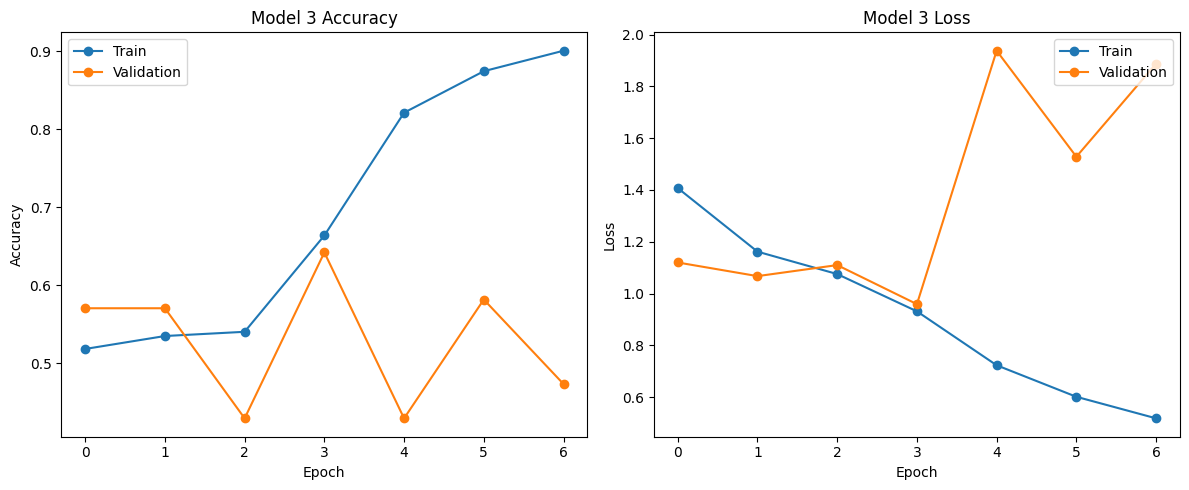

In [47]:
plot_training_performance(history_model3, "Model 3")

In [48]:
model3 = load_model("model3.h5")
model3_predicted_classes = model_test(model3, x_test)
model3_results_df = model_results_df(test_ids, model3_predicted_classes)
save_model_results(model3_results_df, model3, 'model3_results.csv', 'model3.keras')

102/102 [==============================] - 2s 12ms/step
Results saved to model3_results.csv
Model saved as model3.keras


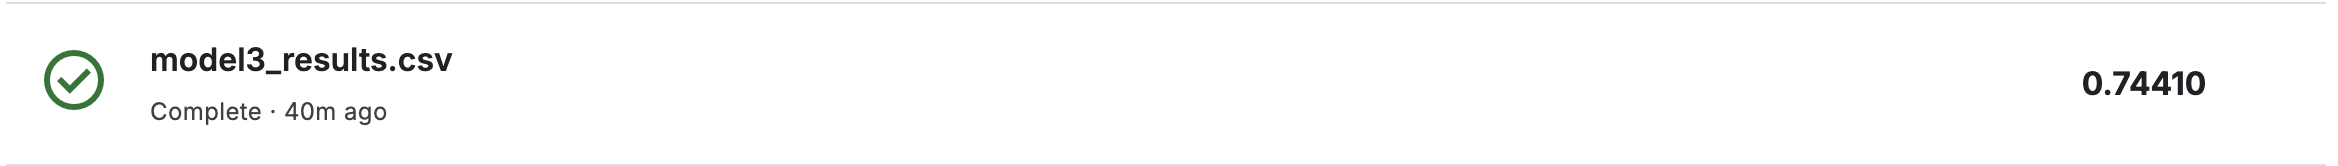

In [49]:
with strategy.scope():
    model4 = Sequential()
    model4.add(Embedding(input_dim = 10000,
                         output_dim = 128,
                         input_length = 100))

    model4.add(LSTM(units = 64,
                    return_sequences = True))
    model4.add(Dropout(0.2))
    model4.add(GRU(units = 32))
    model4.add(Dropout(0.2))
    
    model4.add(Dense(1, activation = 'sigmoid'))
    
    model4.compile(optimizer = 'adam',
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])
    
    print(model4.summary)

    checkpoint = ModelCheckpoint(filepath='model4.h5',
                                 monitor='val_loss',
                                 save_best_only = True,
                                 mode = 'min',
                                 verbose = 1)

    early_stopping = EarlyStopping(monitor = 'val_loss',
                                   patience = 3,
                                   restore_best_weights = True)
    
    history_model4 = model4.fit(x_train,
                                y_train,
                                validation_data = (x_val, y_val),
                                epochs = 10,
                                callbacks = [checkpoint, early_stopping],
                                batch_size = 64)

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x34bbd5fa0>>
Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 0.5548 - accuracy: 0.7110
Epoch 1: val_loss improved from inf to 0.47596, saving model to model4.h5
96/96 [==============================] - 8s 65ms/step - loss: 0.5548 - accuracy: 0.7110 - val_loss: 0.4760 - val_accuracy: 0.7951
Epoch 2/10
95/96 [============================>.] - ETA: 0s - loss: 0.3105 - accuracy: 0.8788
Epoch 2: val_loss did not improve from 0.47596
96/96 [==============================] - 5s 55ms/step - loss: 0.3105 - accuracy: 0.8788 - val_loss: 0.5243 - val_accuracy: 0.7814
Epoch 3/10
95/96 [============================>.] - ETA: 0s - loss: 0.2029 - accuracy: 0.9234
Epoch 3: val_loss did not improve from 0.47596
96/96 [==============================] - 5s 56ms/step - loss: 0.2033 - accuracy: 0.9233 - val_loss: 0.6543 - val_accuracy: 0.7774
Epoch 4/10
95/96 [============================>.] - ETA: 0s - los

In [50]:
model4 = load_model("model4.h5")
model4_predicted_classes = model_test(model4, x_test)
model4_results_df = model_results_df(test_ids, model4_predicted_classes)
save_model_results(model4_results_df, model4, 'model4_results.csv', 'model4.keras')

102/102 [==============================] - 1s 9ms/step
Results saved to model4_results.csv
Model saved as model4.keras


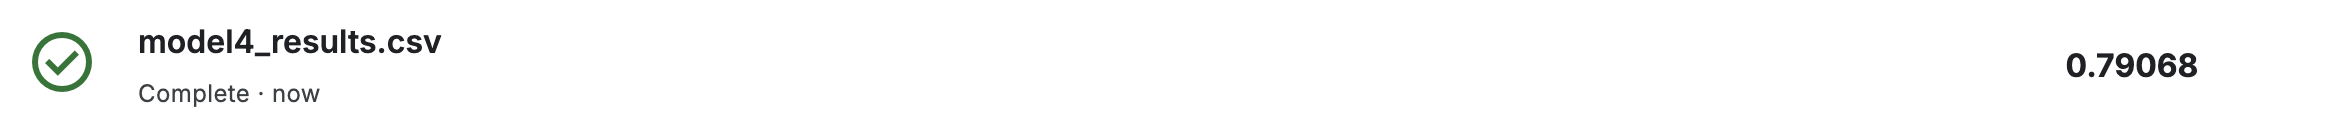

### Discussion

In this project, I explored three distinct model architectures to classify tweets based on sentiment, moving sequentially from LSTM-based models to GRU-based models, and finally to a hybrid model combining both LSTM and GRU layers. The goal was to evaluate each architecture’s effectiveness in capturing the temporal dependencies inherent in tweet text data and improving classification performance. I first implemented a simple LSTM model, achieving a Kaggle test score of 0.79. The LSTM’s ability to retain long-term dependencies made it a natural choice for handling sequential data in tweets, where earlier parts of a sentence can influence the meaning of later words. However, I wanted to investigate whether GRU layers, which require fewer computational resources due to their simpler architecture, could yield comparable results.

When I shifted to a GRU-based model, the Kaggle performance score dropped slightly to 0.78. This result suggested that while the GRU was efficient, it may not have been as effective as the LSTM in capturing complex dependencies in the tweet text data. 

Finally, I experimented with a combined architecture, incorporating both LSTM and GRU layers to leverage the strengths of each. My first hybrid model consisted of 2 LSTM layers and 2 GRU layers. However, this model received a test score of 0.74 perhaps due to the model's complexity and overfitting.


My second hybrid model achieved a test score of 0.79, and consisted of one LSTM layer and one GRU layer. Its test score was almost identical to that of the LSTM-only model. This indicated that the added complexity of combining the two RNN types did not significantly enhance the model’s understanding of the tweet sequences.

The relatively consistent Kaggle scores across these models suggest that while the models can provide a solid baseline for sentiment classification tasks on this dataset, further improvement requires changes beyond just model architecture. Improving the preprocessing of tweets in order to better focus on sentiment-bearing words could yield more representative data inputs and reduce noise. It would help the models focus on the sentiment-relevant parts of the text, potentially enhancing performance across all architectures. In future iterations, these approaches could be tested to further refine the model and improve generalization.

